
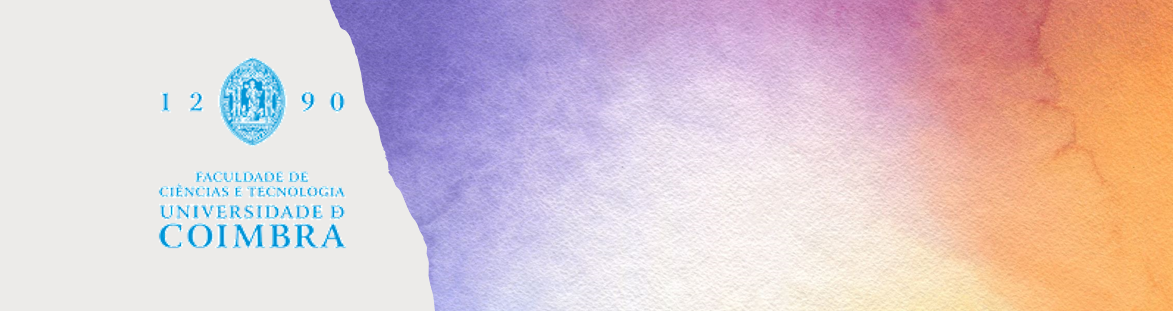

### Projeto de FIAD 2022 - Código | Python 
# Gonçalo Paiva Gouveia 2018277419|MEF
Professores Alberto Cardoso e Jorge Henriques © DEI2021/2022

Objetivo: Pretende-se exemplificar a aplicação da fusão de dados de sensores para obter a estimativa da localização de um robot, usando um filtro de Kalman estendido, Kalman sem descendência, e um filtro de particulas.

Para este projeto foram usados códigos disponibilizados dos trabalhos de aulas práticas.

<font color='red'>Relátorio do Projeto em anexo.</font>



In [2]:
#importar libraries

#pip install filterpy.monte_carlo if needed

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as Rot
import scipy.linalg
from scipy.linalg import sqrtm, inv
import scipy.stats

from filterpy.monte_carlo import systematic_resample

from numpy.random import uniform
from numpy.linalg import norm
from numpy.random import randn

from sklearn.metrics import mean_squared_error, r2_score
import time as tt
from numpy.random import uniform


# %matplotlib inline 


In [3]:
# Estimation parameters of EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
R = np.diag([1.0, 1.0])**2  # Observation x,y position covariance

#  Simulation parameter
GPS_Noise = np.diag([0.5, 0.5])**2
Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

#  UKF Parameter
ALPHA = 0.001
BETA = 2
KAPPA = 0


#inicializar vetores de metricas
mse_dr = []
rmse_dr = []
r2_dr = []

mse_ekf = []
rmse_ekf = []
r2_ekf = []

mse_ukf = []
rmse_ukf = []
r2_ukf = []

mse_pf = []
rmse_pf = []
r2_pf = []

In [4]:

def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

In [5]:
#codigo folha 4

def motion_model(x, u):
    F = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
    ])

    B = np.array([
        [np.cos(x[2])[0], 0],
        [np.sin(x[2])[0], 0],
        [0, dt],
        [1, 0],
    ])
    
    x = F.dot(x) + B.dot(u)
    
    return x

In [6]:
#classes code

def observation(xTrue, xd, u, efk=True):
    if efk:
        xTrue = motion_model(xTrue, u)

        # add noise to GPS x-y
        zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
        zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
        z = np.array([[zx, zy]])
    
        # add noise to input
        ud1 = u[0, 0] + np.random.randn() * Input_Noise[0, 0]
        ud2 = u[1, 0] + np.random.randn() * Input_Noise[1, 1]
        ud = np.array([[ud1, ud2]]).T
    
        xd = motion_model(xd, ud)
    
        return xTrue, z, xd, ud
    
    else:
        xTrue = motion_model(xTrue, u)
    
        # add noise to gps x-y
        z = observation_model(xTrue) + GPS_Noise @ np.random.randn(2, 1)
    
        # add noise to input
        ud = u + Input_Noise @ np.random.randn(2, 1)
    
        xd = motion_model(xd, ud)
    
        return xTrue, z, xd, ud

In [7]:
#classes code

def observation(xTrue, xd, u, efk=True):
    if efk:
        xTrue = motion_model(xTrue, u)

        # add noise to GPS x-y
        zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
        zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
        z = np.array([[zx, zy]])
    
        # add noise to input
        ud1 = u[0, 0] + np.random.randn() * Input_Noise[0, 0]
        ud2 = u[1, 0] + np.random.randn() * Input_Noise[1, 1]
        ud = np.array([[ud1, ud2]]).T
    
        xd = motion_model(xd, ud)
    
        return xTrue, z, xd, ud
    
    else:
        xTrue = motion_model(xTrue, u)
    
        # add noise to gps x-y
        z = observation_model(xTrue) + GPS_Noise @ np.random.randn(2, 1)
    
        # add noise to input
        ud = u + Input_Noise @ np.random.randn(2, 1)
    
        xd = motion_model(xd, ud)
    
        return xTrue, z, xd, ud

In [8]:
#classes code

def observation_model(x):
    H = np.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0]
    ], dtype=float)
    
    z = H @ x
    return z

def jacobH(x):                           # Jacobian of Observation Model
    jH = np.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0]
    ], dtype=float)
    
    return jH

def jacobF(x, u):                         # Jacobian of Motion Model
    v = u[0][0]
    phi = x[2][0]


    jF = np.array([
        [1.0, 0.0, -v * np.sin(phi) * dt, np.cos(phi) * dt],
        [1.0, 0.0, v * np.cos(phi) * dt, np.sin(phi) * dt],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ], dtype=float)
    
    return jF
    

# EKF - Extended Kalman Filter


In [9]:
#classes code

def ekf_estimation(xEst, PEst, z, u):

    #oooOOOooo Predict oooOOOooo
    xPred = motion_model(xEst, u)
    pPred = jacobF(xEst, u) @ PEst @ jacobF(xEst, u).T + Q

    #oooOOOooo Update oooOOOooo
    
    
    jacobiana = jacobH(xPred)
    zPred = observation_model(xEst)
    y = z.T - zPred
    S = jacobiana @ pPred @ jacobiana.T + R;S = S.astype(float)
    K = pPred @ jacobiana.T @ np.linalg.inv(S)
    
    xEst = xPred + K @ y
    PEst = (np.eye(len(xEst)) - K @ jacobiana) @ pPred

    return xEst, PEst

In [10]:
def main_ekf():
    print("Robot simulation start!")

    time = 0.0

    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((1, 2))

    while SIM_TIME >= time:
        time += dt
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u)

        xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.vstack((hz, z))
    return hxEst,hxDR,hxTrue,hz,xEst,PEst
       

# UKF - Uncentered Kalman Filter

In [11]:
def setup_ukf(nx):
    # calculate lambda
    lamb = ALPHA ** 2 * (nx + KAPPA) - nx
    # calculate the weights
    # w^(0)
    wm = [lamb / (lamb + nx)] # wm corresponds to w of the UKF Algorithm
    # wc^(0)
    wc = [(lamb / (lamb + nx)) + (1 - ALPHA ** 2 + BETA)]
    for i in range(2 * nx):
        # w^(+-i)
        wm.append(1.0 / (2 * (nx + lamb)))
        # wc^(+-i)
        wc.append(1.0 / (2 * (nx + lamb)))
    
    # define gamma
    gamma = math.sqrt(nx + lamb)

    wm = np.array([wm])
    wc = np.array([wc])

    return wm, wc, gamma



def ukf_estimation(xEst, PEst, z, u, wm, wc, gamma):
    def generate_sigma_points(xEst, PEst, gamma):
        # Calculate the sigma points using xEst (xhat_k|k), PEst (P_k|k) and gamma
        # or using xPred (xhat_k|k-1), PPred (P_k|k-1) and gamma

        x_0 = xEst

        sigma_neg = xEst - gamma * sqrtm(PEst)
        sigma_pos = xEst + gamma * sqrtm(PEst)

        return np.concatenate((x_0, sigma_neg, sigma_pos), axis=1)
    
    def predict_sigma_motion(sigma, u):
        # Sigma Points prediction with motion model
        return motion_model(sigma, u)
    
    def predict_sigma_observation(sigma):
        # Sigma Points prediction with observation model
        return observation_model(sigma)
    
    def calc_sigma_covariance(x, sigma, wc, Pi):
        # Calculate the covariance P = PPred (P_k|k-1) using x = xPred (xhat_k+1|k),
        # sigma (x^(i)_k+1|k), wc and Pi = Q (initial value of PPred)
        # or calculate the covariance P = st (P^yy_t|t-1) using x = zb (yhat_t),
        # sigma = z_sigma (y^(i)_t), wc and Pi = R (initial value of st)
        return wc * (sigma-x) @ (sigma-x).T + Pi 
    
    def calc_pxz(sigma, x, z_sigma, zb, wc):
        # Calculate the covariance Pxz (P^xy_t|t-1) using wc, sigma (x^(i)_t|t-1),
        # x (xhat_t|t-1), z_sigma (y^(i)_t) and zb (yhat_t) and 
        return wc * (sigma-x) @ (z_sigma-zb).T
    
    #  Predict (UKF - time update)
    
    # Calculate the sigma-points using xExt (xhat_k|k) and PEst (P_k|k)
    # and gamma in def generate_sigma_points
    sigma = generate_sigma_points(xEst, PEst, gamma)
    
    # Propagate the sigma-points (x^(i)_k+1|k = f(x^(i)_k|k , w^(i)_k)) 
    # using the sigma-points obtained in the previous calculus and u (ud = noisy u)
    # in def predict_sigma_motion
    sigma_propagated = predict_sigma_motion(sigma, u)

    # Calculate xPred (xhat_k+1|k) using wm and the propagated sigma-points 
    xPred = wm @ sigma_propagated.T  
    xPred = xPred.T
    
    # Calculate PPred (P_k|k-1) using xPred, the propagated sigma-points
    # wc and Q in def calc_sigma_covariance
    PPred = calc_sigma_covariance(xPred, sigma_propagated, wc, Q)

    
    #  Update (UKF - measurement update)
    
    # Calculate zPred (yhat_t) using xPred (xhat_k+1|k) in def observation_model
    zPred = observation_model(xPred)
    
    # Calculate y = (y_t - yhat_t) using z (y_t) and zPred (yhat_t)
    y = z - zPred
     
    # Calculate the sigma-points using xPred (xhat_k|k-1), PPred (P_k|k-1)
    # and gamma in def generate_sigma_points
    sigma = generate_sigma_points(xPred, PPred, gamma)
    
    # Propagate the sigma-points z_sigma (y^(i)_t = h(x^(i)_t|t-1 , e^(i)_t)) 
    # using the propagated sigma-points in def predict_sigma_observation
    z_sigma = predict_sigma_observation(sigma)
    
    # Calculate zb (yhat_t) using wm and the propagated sigma-points z_sigma
    zb = wm @ z_sigma.T
    zb = zb.T
    
    # Calculate the sigma covariance, st (P^yy_t|t-1), using zb (yhat_t),
    # z_sigma (y^(i)_t), wc and R in def calc_sigma_covariance
    st = calc_sigma_covariance(zb, z_sigma, wc, R.T)
    
    # Calculate Pxz (P^xy_t|t-1) using sigma (x^(i)_t|t-1), xPred (xhat_t|t-1),
    # z_sigma (y^(i)_t), zb (yhat_t) and wc in def calc_pxz
    Pxz = calc_pxz(sigma, xPred, z_sigma, zb, wc)    
    
    # Calculate K_t using Pxz (P^xy_t|t-1) and st (P^yy_t|t-1)
    K_t = Pxz @ inv(st.astype(float))
    
    # Update xEst (Xhat_t|t) using xPred (xhat_t|t-1), K_t and y (y_t - yhat_t)
    xEst = xPred + K_t @ y
    
    # Update PEst (P_t|t) using PPred (P_t|t-1), K_t and st (P^yy_t|t-1)
    PEst = PPred - K_t @ st @ K_t.T
    
    return xEst, PEst

In [12]:
#main cicle for UKF method

def main_ukf():
    print('simualtion starting!')
    nx = 4  # State Vector [x y yaw v]'

    xEst = np.zeros((nx, 1))
    xTrue = np.zeros((nx, 1))
    PEst = np.eye(nx)

    wm, wc, gamma = setup_ukf(nx)

    xDR = np.zeros((nx, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))
    
    time = 0.0
    
    while SIM_TIME >= time:
        time += dt
        # effective values of the input variables (v and omega)
        u = calc_input()
        
        # xTrue: x_k|k-1 (given by the motion_model using x and u)
        # z: noisy GPS output variables (given by observation_model)
        # xDR: xDR_k|k-1 (given by the motion_model using xDR_k-1 and noisy u)
        # ud: noisy u
        xTrue, z, xDR, ud = observation(xTrue, xDR, u, False)

        # Estimation of xEst, PEst using the UKF algorithm 
        xEst, PEst = ukf_estimation(xEst, PEst, z, ud, wm, wc, gamma)

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))        
        hz = np.vstack((hz, z))
        
    return hxEst


# PF - Particle Filter 

In [13]:

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)%(2*np.pi)
    return particles

def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def neff(weights):
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [22]:
def main_pf():

    time = 0
    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)
    hxmu = np.array(xTrue[:2])


    N = Number_particles  # Number of particles

    # Landmarks
    landmarks = np.array([[0, 0],[100, 100],[0, 200],[-100, 100]])
    NL = len(landmarks)


    # create particles and weights

    particles = create_uniform_particles((0,40), (0,40), (0, 6.28), N)
    weights = np.ones(N) / N   

    xs = []
    robot_pos = np.array([0., 0.])
    sensor_std_err = 0.5

    while SIM_TIME >= time:
        time += dt
        u = calc_input()



        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)

            
        mu, var = estimate(particles, weights)

        hxmu = np.hstack((hxmu, np.array([mu]).T))

        
    return hxmu
    


run number 1
run number 5
run number 10
run number 15
run number 20
run number 30
run number 40
run number 50
run number 60
run number 70
run number 80
run number 90
run number 99


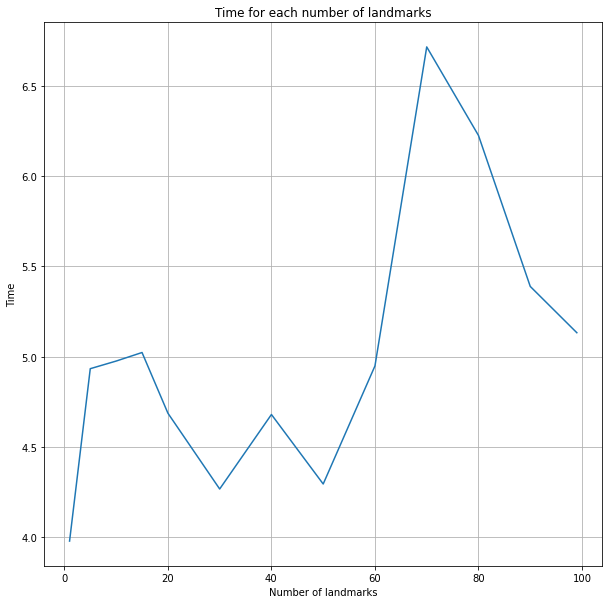

In [24]:
'''
set plot = False se quiser fazer plot dos diferentes experimentos com o numero de landmarks


Estava indeciso se fazia plot com a metrica de tempo de conclusão
ou se fazia o mesmo adquirindo o tempo de processo de cada

Para o código do filtro de particulas necessitei de ajuda de colegas.
'''


def test_number_landmarks(plot = True):
    clock = []
    dt_number_particles = 1
    
    N = 1000

    # Particles
    landmarks = np.zeros((100, 2))

    # create particles and weights
    particles = create_uniform_particles((0, 200), (-100, 100), (0, 6.28), N)
    weights = np.ones(N) / N   

    xs = []
    robot_pos = np.array([0., 0.])
    sensor_std_err = 0.5

    var_seed = [1,5,10,15,20,30,40,50,60,70,80,90,99]
    
    for i in var_seed:
        print(f'run number {i}')
        start = tt.time()
        time = 0.0
        
        # State Vector [x y yaw v]'
        xEst = np.zeros((4, 1))
        xTrue = np.zeros((4, 1))
        PEst = np.eye(4)
    
        xDR = np.zeros((4, 1))  # Dead reckoning
    
        # history
        hxTrue = xTrue
        hxDR = xTrue
        hxmu = np.array(xTrue[:2])
        hz = np.zeros((1, 2))
        while SIM_TIME >= time:
            
            app_x = np.random.randint(0, 61)
            app_y = np.random.randint(0, 21)
            aux = np.array([app_x, app_y])
            landmarks[i] = aux
            NL = len(landmarks)

            time += dt_number_particles
            u = calc_input()

            xTrue, z, xDR, ud = observation(xTrue, xDR, u)

            # store data history
            hxDR = np.hstack((hxDR, xDR))
            hxTrue = np.hstack((hxTrue, xTrue))
            hz = np.vstack((hz, z))

            # print(z)
            robot_pos = z

            zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

            predict(particles, u=(0.00, 1.414), std=(.2, .05))

            # incorporate measurements
            update(particles, weights, z=zs, R=sensor_std_err, 
                   landmarks=landmarks)

            # resample if too few effective particles
            if neff(weights) < N/2:
                indexes = systematic_resample(weights)
                resample_from_index(particles, weights, indexes)
                
            mu, var = estimate(particles, weights)

            hxmu = np.hstack((hxmu, np.array([mu]).T))
        clock.append(tt.time() - start)    
       
        if plot == True:
            plt.figure(figsize=(10, 10))


            plt.plot(hz[:, 0], hz[:, 1], ".g",label="GPS Signal")
            plt.plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b",label="True Position")
            plt.plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k",label="Dead-Reckoning")
            plt.plot(hxmu[0, :].flatten(), hxmu[1, :].flatten(), "-y",label="Particle Filter")
            plt.scatter(landmarks[:, 0], landmarks[:, 1], color='deeppink', marker="D", label="Landmarks")

            plt.title("Number of seeds: " + str(i + 1))

            plt.axis("equal")
            plt.grid()
            plt.legend()
            plt.show()
        
     
    plt.figure(figsize=(10, 10))
    plt.title("Time for each number of landmarks")
    plt.plot(var_seed, clock)
    plt.xlabel("Number of landmarks")
    plt.ylabel("Time")
    plt.grid(True)
    plt.show()
test_number_landmarks(False)   

#Due to stochastics method este grafico pode variar abruptamente até mesmo a sua monotonia

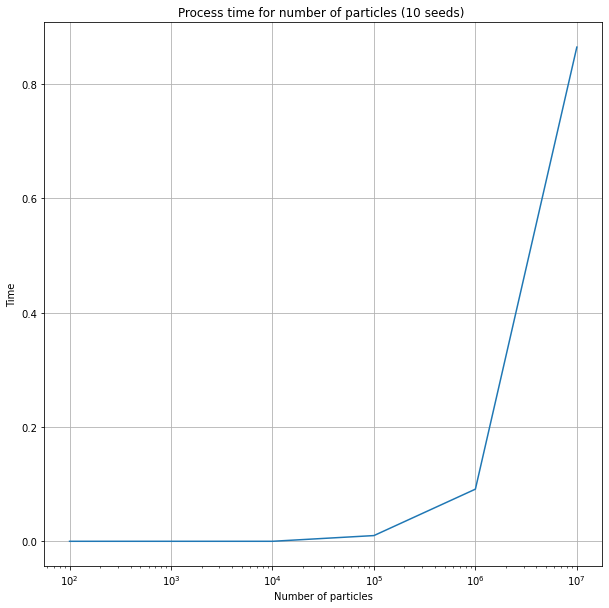

In [15]:
def test_number_particles():

    time = 0
    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)
    hxmu = np.array(xTrue[:2])


    N = [50,10**2,10**3,10**4,10**5,10**6,10**7]  # Number of particles

    # Landmarks
    landmarks = np.array([[0, 0],[100, 100],[0, 200],[-100, 100]])
    NL = len(landmarks)

    clock = []
    # create particles and weights
    
    for i in N:
    
        start = tt.time()
        particles = create_uniform_particles((0,40), (0,40), (0, 6.28), i)
        weights = np.ones(i) / i   

        xs = []
        robot_pos = np.array([0., 0.])
        sensor_std_err = 0.5

        while SIM_TIME >= time:
            time += dt
            u = calc_input()



            zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

            predict(particles, u=(0.00, 1.414), std=(.2, .05))

            # incorporate measurements
            update(particles, weights, z=zs, R=sensor_std_err, 
                   landmarks=landmarks)

            # resample if too few effective particles
            if neff(weights) < i/2:
                indexes = systematic_resample(weights)
                resample_from_index(particles, weights, indexes)


            mu, var = estimate(particles, weights)

            hxmu = np.hstack((hxmu, np.array([mu]).T))
        clock.append(tt.time() - start)    

    plt.figure(figsize=(10, 10))
    plt.plot(N[1:],clock[1:])
    plt.xscale('log')
    plt.grid(True)
    plt.title('Process time for number of particles (10 seeds) ')
    plt.xlabel("Number of particles")
    plt.ylabel("Time")
    
test_number_particles()


In [16]:
def main_pf():
    time = 0.0

    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning
    show_animation = True
    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hxmu = np.array(xTrue[:2])
    hz = np.zeros((1, 2))


    N = 1000

    # Particles
    landmarks = np.array([[0, 0],[100, 100],[0, 200],[-100, 100]])
    NL = len(landmarks)


    # create particles and weights

    particles = create_uniform_particles((0,40), (0,40), (0, 6.28), N)
    weights = np.ones(N) / N   

    xs = []
    robot_pos = np.array([0., 0.])
    sensor_std_err = 0.5

    while SIM_TIME >= time:
        time += dt
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u)

        # store data history

        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.vstack((hz, z))

        # print(z)
        robot_pos = z

        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
       
        mu, var = estimate(particles, weights)

        hxmu = np.hstack((hxmu, np.array([mu]).T))

    return hxmu
    

# Elipse de covariância e Métricas

In [17]:
#classes code

def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r", label= ' covariance elipse' )
    #plt.show()


In [18]:
'''
escolho as segintes metricas mse e rmse para fazer a analise de dados, e poder calcular o absolute error
uso o r2 para etsimar como metrica para avaliar se a simulação está perto dos dados reais
'''
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Estimação de Parâmetros

Robot simulation start!
simualtion starting!


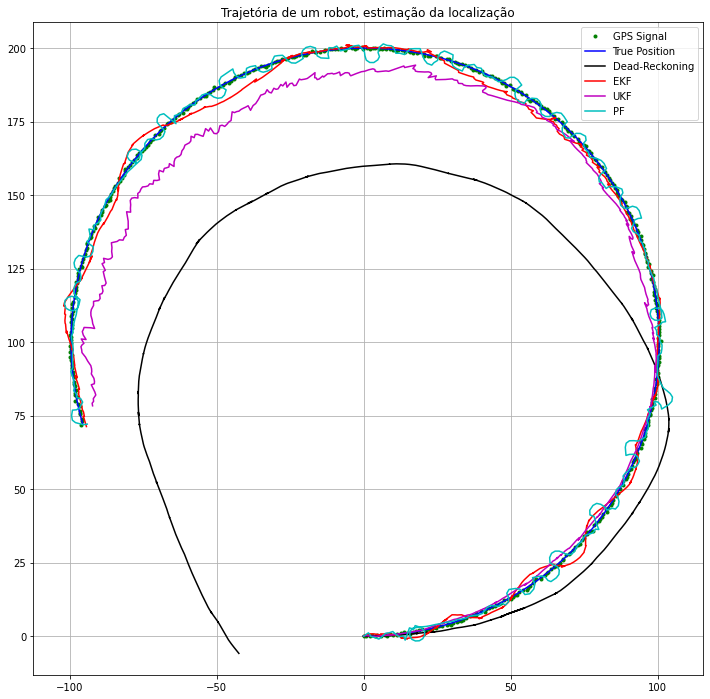

(1348.736904511857,
 34.59125915047249,
 0.6996277838027882,
 3.674880224979062,
 1.914968669086102,
 0.9992119727659861,
 21.572809008189466,
 4.62924571889037,
 0.995457835123424,
 4.555564332143508,
 2.1321407149336244,
 0.999023154879542)

In [19]:
 %matplotlib inline

def main(plot=True):
    #metodos outros metodos 
    hxEst_EKF,hxDR,hxTrue,hz,xEst,PEst =  main_ekf()
    hxEst_UKF = main_ukf()
    hxEst_PF = main_pf()
    
    
    if plot == True:
        
        #plot_covariance_ellipse(xEst, PEst)
        
        plt.figure(figsize=(12, 12))
        plt.plot(hz[:, 0], hz[:, 1], ".g",label="GPS Signal")
        plt.plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b",label="True Position")
        plt.plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k",label="Dead-Reckoning")
        plt.plot(hxEst_EKF[0, :].flatten(), hxEst_EKF[1, :].flatten(), "-r", label="EKF")
        plt.plot(hxEst_UKF[0, :].flatten(), hxEst_UKF[1, :].flatten(), "-m", label="UKF")
        plt.plot(hxEst_PF[0, :].flatten(), hxEst_PF[1, :].flatten(), "-c", label="PF")

        plt.axis("equal")
        plt.grid(True)
        plt.legend()
        plt.title('Trajetória de um robot, estimação da localização')
        plt.show()
    
    return mse(hxTrue.T[:, :2], hxDR.T[:, :2]), rmse(hxTrue.T[:, :2], hxDR.T[:, :2]), r2(hxTrue.T[:, :2], hxDR.T[:, :2]), mse(hxTrue.T[:, :2], hxEst_EKF.T[:, :2]), rmse(hxTrue.T[:, :2], hxEst_EKF.T[:, :2]), r2(hxTrue.T[:, :2], hxEst_EKF.T[:, :2]), mse(hxTrue.T[:, :2], hxEst_UKF.T[:, :2]), rmse(hxTrue.T[:, :2], hxEst_UKF.T[:, :2]), r2(hxTrue.T[:, :2], hxEst_UKF.T[:, :2]), mse(hxTrue.T[:, :2], hxEst_PF.T), rmse(hxTrue.T[:, :2], hxEst_PF.T), r2(hxTrue.T[:, :2], hxEst_PF.T)
        
main()

In [20]:


for i in range(10):
    # True position, dead-reckoning, ekf, ukf, particle filter
    
    print(f'Simulation number: {i+1}')
    
    #set main(False) I want no Plot
    
    mse_hxDR, rmse_hxDR, r2_hxDR, mse_hxEst, rmse_hxEst, r2_hxEst, mse_hxEst_2, rmse_hxEst_2, r2_hxEst_2, mse_hxmu, rmse_hxmu, r2_hxmu = main(False)

    mse_dr.append(mse_hxDR)
    rmse_dr.append(rmse_hxDR)
    r2_dr.append(r2_hxDR)

    mse_ekf.append(mse_hxEst)
    rmse_ekf.append(rmse_hxEst)
    r2_ekf.append(r2_hxEst)

    mse_ukf.append(mse_hxEst_2)
    rmse_ukf.append(rmse_hxEst_2)
    r2_ukf.append(r2_hxEst_2)

    mse_pf.append(mse_hxmu)
    rmse_pf.append(rmse_hxmu)
    r2_pf.append(r2_hxmu)
    
print('simulation ended!')
mse_dr_mean = np.average(mse_dr)
mse_dr_std = np.std(mse_dr)
rmse_dr_mean = np.average(rmse_dr)
rmse_dr_std = np.std(rmse_dr)
r2_dr_mean = np.average(r2_dr)
r2_dr_std = np.std(r2_dr)

mse_ekf_mean = np.average(mse_ekf)
mse_ekf_std = np.std(mse_ekf)
rmse_ekf_mean = np.average(rmse_ekf)
rmse_ekf_std = np.std(rmse_ekf)
r2_ekf_mean = np.average(r2_ekf)
r2_ekf_std = np.std(r2_ekf)

mse_ukf_mean = np.average(mse_ukf)
mse_ukf_std = np.std(mse_ukf)
rmse_ukf_mean = np.average(rmse_ukf)
rmse_ukf_std = np.std(rmse_ukf)
r2_ukf_mean = np.average(r2_ukf)
r2_ukf_std = np.std(r2_ukf)

mse_pf_mean = np.average(mse_pf)
mse_pf_std = np.std(mse_pf)
rmse_pf_mean = np.average(rmse_pf)
rmse_pf_std = np.std(rmse_pf)
r2_pf_mean = np.average(r2_pf)
r2_pf_std = np.std(r2_pf)

absol_dr =  abs(mse_dr_mean-mse_dr_std)/mse_dr_mean
absol_ekf =abs( mse_ekf_mean-mse_ekf_std)/mse_ekf_mean
absol_ukf = abs(mse_ukf_mean-mse_ukf_std)/mse_ukf_mean
absol_pf = abs(mse_pf_mean-mse_pf_std)/mse_pf_mean
    
    
    
#   criar tabela com todas as metricas


stats = pd.DataFrame(
    np.array([[mse_dr_mean,  mse_dr_std,  absol_dr,  rmse_dr_mean,  rmse_dr_std,  r2_dr_mean],
              [mse_ekf_mean, mse_ekf_std, absol_ekf, rmse_ekf_mean, rmse_ekf_std, r2_ekf_mean],
              [mse_ukf_mean, mse_ukf_std, absol_ukf, rmse_ukf_mean, rmse_ukf_std, r2_ukf_mean],
              [mse_pf_mean,  mse_dr_std,  absol_pf,  rmse_pf_mean,  rmse_pf_std,  r2_pf_mean]]),
    columns=[
        "MSE_mean",
        "MSE_std",
        'Absolute Error',
        "RMSE_mean",
        "RMSE_std",
        "R^2_mean"
    ],
    index=[
        "Dead-Reckoning",
        "EKF",
        "UKF",
        "Particle Filter"
    ]
)

stats



Simulation number: 1
Robot simulation start!
simualtion starting!
Simulation number: 2
Robot simulation start!
simualtion starting!
Simulation number: 3
Robot simulation start!
simualtion starting!
Simulation number: 4
Robot simulation start!
simualtion starting!
Simulation number: 5
Robot simulation start!
simualtion starting!
Simulation number: 6
Robot simulation start!
simualtion starting!
Simulation number: 7
Robot simulation start!
simualtion starting!
Simulation number: 8
Robot simulation start!
simualtion starting!
Simulation number: 9
Robot simulation start!
simualtion starting!
Simulation number: 10
Robot simulation start!
simualtion starting!
simulation ended!


,MSE_mean,MSE_std,Absolute Error,RMSE_mean,RMSE_std,R^2_mean
Dead-Reckoning,1488.562197,1263.799858,0.150993,33.123186,14.492542,0.675951
EKF,10.942873,5.581821,0.489913,3.182090,0.879177,0.997657
UKF,9.922929,7.092315,0.285260,2.965564,1.030018,0.997907
Particle Filter,4.857255,1263.799858,0.911920,2.197327,0.095491,0.998962
